# Forcasting with ML and ML tricks!
following [this course collab](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb#scrollTo=iL2DDjV3lel6) 

[And this is a video explainng the code](https://youtu.be/q3wWjtCsaLc)

pattern we developed in earlier notbooks


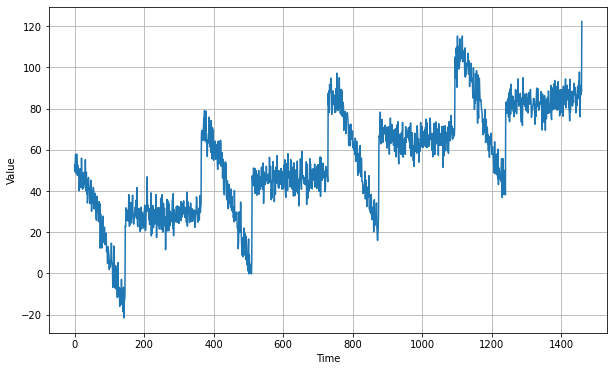

In [1]:
# Setup and stuff from prevvious notebooks

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras


def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

    time = np.arange(4 * 365 + 1)

time = np.arange(4 * 365 + 1)
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
print("pattern we developed in earlier notbooks")
plt.show()

The model will forcast(predict) the next value given the previous 30 values. So we create a dataset of 30-value windows to train with

In [2]:
# from the window notebook we have this function (previous notebook)

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset  

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [4]:
# these 3 lines ensure repeatlabilty of the results since machine learning weights are random
keras.backend.clear_session()
tf.random.set_seed(43)
np.random.seed(43)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])



## Trick 1 finding the best learning rate

In [5]:
# using a learning rate schedule we can keep chaning the leraning rate until we
# find the best rate

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30)
)
# this means that we start with a very small learning rate of 10^-6 and increase
# it gradually so that every 30 eppchs we multiply the lr by 10

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
#Nore about using Huber loss: it is quadratic for small erros just like
# mean square error, but linear for big errors like mean absolute error
# We could've used mean absolute error as loss function, but Huber loss converges
# better
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 25.6799 - mae: 26.1769 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 14.2951 - mae: 14.7876 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.7323 - mae: 11.2203 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 10.6206 - mae: 11.1086 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 10.5486 - mae: 11.0377 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 10.4828 - mae: 10.9725 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 10.4167 - mae: 10.9050 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 10.3257 - mae: 10.8138 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 10.2435 - mae: 10.7328 

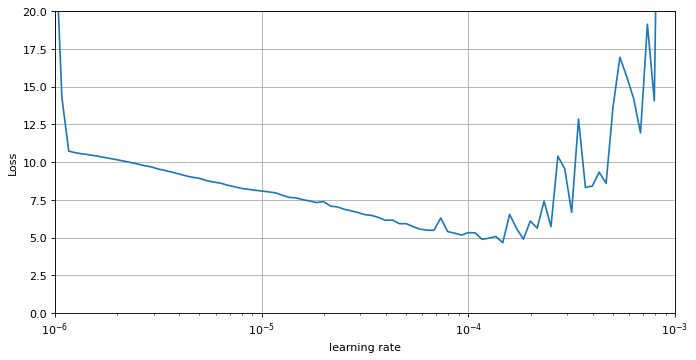

In [6]:
# we can see the learning rate performance

plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])
plt.grid()

We see from the figure above that the best learning rate is between 10^-5 and 10^-4 things after 10-4 become unstable and we don't want that, so a good rate is moreless 10^-5

## Trick 2 Early stoppage 
This call back stops training when the model has stopped making validation progress.
If the val error stops going down for x epochs the training will stop
x epochs are called 'patience' and we'll set em to 10 here

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 10ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - l

We set the training to 500 epochs but the model stopped on its own when the val error stopped improving. it stopped at epoch 222 (at this specific run)

In [10]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forcast = model.predict(ds)
  return forcast

 shape before (461, 1)
after removing the unneed dim (461,)
Our current error is:  5.1662674


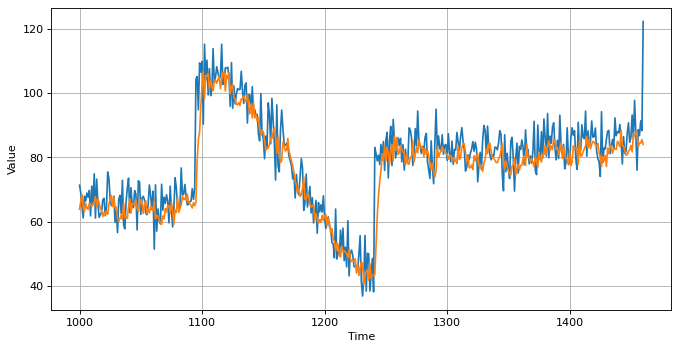

In [17]:
# we make predictions with the validation set
# https://youtu.be/q3wWjtCsaLc?t=404

lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
print(" shape before", lin_forecast.shape)
# we get rid of the preidiction dim cuz our forcast doesn't have a "classifcation" nature
lin_forecast = lin_forecast[:, 0]
print("after removing the unneed dim", lin_forecast.shape)

plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

print("Our current error is: ", keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy())

The current mae is not the best, let's try to imporuve it

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.3203 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 12.6771 - mae: 13.1682 

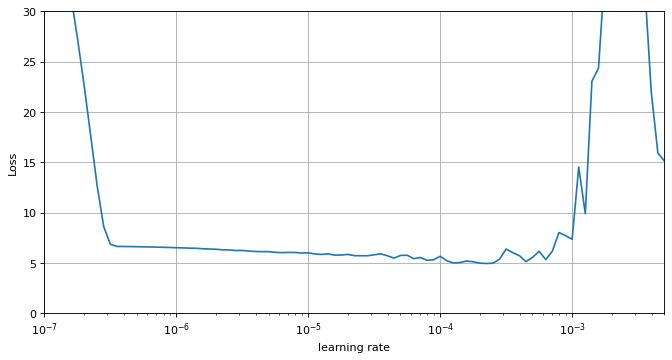

In [22]:
# find the best learning rate
plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])
plt.grid()

In [21]:
# After getting the best learning rate of about 10^-5, apply it with early stopping
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 9ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 6.9028 

 shape before (461, 1)
after removing the unneed dim (461,)
Our current error is:  5.2025557


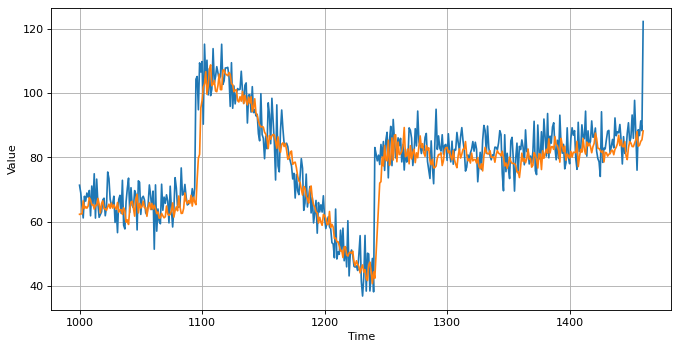

In [23]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
print(" shape before", lin_forecast.shape)
# we get rid of the preidiction dim cuz our forcast doesn't have a "classifcation" nature
lin_forecast = lin_forecast[:, 0]
print("after removing the unneed dim", lin_forecast.shape)

plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

print("Our current error is: ", keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy())

This is forcast model is better than the one bfore, but not better than our best model (the one made without ML in the previous notebook) but we got this good a result without doing any of the data pre-processing like we did in that notebook. We didn't do any moving average or anything